In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in Google Drive (Modify this path accordingly)
zip_path = "/content/drive/My Drive/DataSet2.zip"

# Ensure the file is a zip before extracting
if zip_path.endswith('.zip'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')  # Extract files to the 'data' directory
    print("Extraction complete.")
else:
    print("Uploaded file is not a zip archive.")

Mounted at /content/drive
Extraction complete.


In [ ]:
import os

# Path to the extracted data folder
Alzheimer = "data/DataSet2/prepAlz"  # Change this path if necessary
Brain_Tumour = "data/DataSet2/prepBrain"  # Change this path if necessary
Parkinson = "data/DataSet2/prepPark"  # Change this path if necessary
dd = [Alzheimer, Brain_Tumour, Parkinson]

for data_dir in dd:
  print('\n')
  # Get all subdirectories (folders) in the data directory
  folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
  print(f"Data directory: {data_dir}")

  # Display folders and count images in each
  for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    # Count image files (assuming common image extensions)
    image_count = len([file for file in os.listdir(folder_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))])
    print(f"Folder: {folder}, Number of images: {image_count}")




Data directory: data/DataSet2/prepAlz
Folder: Non Demented, Number of images: 67222
Folder: Very mild Dementia, Number of images: 13725
Folder: Moderate Dementia, Number of images: 488
Folder: Mild Dementia, Number of images: 5002


Data directory: data/DataSet2/prepBrain
Folder: glioma, Number of images: 1321
Folder: notumor, Number of images: 1595
Folder: meningioma, Number of images: 1339
Folder: pituitary, Number of images: 1457


Data directory: data/DataSet2/prepPark
Folder: Moderate-Demented, Number of images: 2276
Folder: Non-Demented, Number of images: 3048
Folder: Mild-Demented, Number of images: 1988
Folder: Severe-Demented, Number of images: 1648
Folder: Very-Mild-Demented, Number of images: 2444


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

In [ ]:
# Custom Dataset Class
# -------------------------
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []# Custom Dataset Class
# -------------------------
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.image_counts = defaultdict(int)

        # Assign class indices manually
        class_idx = 0
        for disease in sorted(os.listdir(root_dir)):
            disease_path = os.path.join(root_dir, disease)
            if os.path.isdir(disease_path):
                for class_name in sorted(os.listdir(disease_path)):
                    class_path = os.path.join(disease_path, class_name)
                    if os.path.isdir(class_path):
                        if class_name not in self.class_to_idx:
                            self.class_to_idx[class_name] = class_idx
                            class_idx += 1

                        for img_name in os.listdir(class_path):
                            img_path = os.path.join(class_path, img_name)
                            self.samples.append((img_path, self.class_to_idx[class_name]))
                            self.image_counts[class_name] += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
        self.class_to_idx = {}
        self.image_counts = defaultdict(int)


In [ ]:
# Data Preprocessing
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = CustomImageDataset(root_dir="data/DataSet2", transform=transform)

# Extract labels for stratified split
all_labels = [label for _, label in dataset.samples]
all_indices = np.arange(len(dataset))

# Perform train (70%) split first
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    all_indices, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)

# Perform validation (15%) and test (15%) split on remaining data
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=42
)

# Create datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Total images: {len(dataset)}")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


Total images: 103553
Training set: 72487 images
Validation set: 15533 images
Test set: 15533 images


In [ ]:
from collections import Counter

# Get labels from the train dataset
train_labels = [dataset.samples[i][1] for i in train_idx]  # Extract labels using train_idx

# Count occurrences of each class
class_counts = Counter(train_labels)

# Print the number of images per class
print("Number of images per class in the training set:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Number of images per class in the training set:
Class 2: 47055 images
Class 10: 2134 images
Class 4: 925 images
Class 3: 9607 images
Class 0: 3501 images
Class 5: 937 images
Class 11: 1154 images
Class 8: 1392 images
Class 9: 1593 images
Class 7: 1020 images
Class 6: 1116 images
Class 1: 342 images
Class 12: 1711 images


In [ ]:
# -------------------------
# Model Definition
# -------------------------

model = models.resnet50(pretrained=True)
num_classes = len(dataset.class_to_idx)
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),  # Dropout layer with 40% probability
    nn.Linear(model.fc.in_features, num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training Loop
num_epochs = 12
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"Starting training on {device}...")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


Starting training on cuda...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()

    # Training Phase
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        running_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            running_val_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = correct_val / total_val
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    if epoch == 8:
      for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.1  # Reduce learning rate
      print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']} at epoch {epoch+1}")


    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        print(f"Epoch {epoch+1}: val_accuracy improved from {best_val_acc:.5f} to {val_acc:.5f}, saving model")
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    else:
        print(f"Epoch {epoch+1}: val_accuracy did not improve from {best_val_acc:.5f}")

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {elapsed_time:.2f}s - train_acc: {train_acc:.4f} - val_acc: {val_acc:.4f}")

Epoch 1: val_accuracy improved from 0.00000 to 0.86068, saving model
Epoch 1/12 - 782.59s - train_acc: 0.7895 - val_acc: 0.8607


Epoch 2: val_accuracy improved from 0.86068 to 0.92641, saving model
Epoch 2/12 - 774.57s - train_acc: 0.9112 - val_acc: 0.9264


Epoch 3: val_accuracy improved from 0.92641 to 0.95294, saving model
Epoch 3/12 - 765.87s - train_acc: 0.9463 - val_acc: 0.9529


Epoch 4: val_accuracy improved from 0.95294 to 0.96015, saving model
Epoch 4/12 - 759.11s - train_acc: 0.9593 - val_acc: 0.9601


Epoch 5: val_accuracy did not improve from 0.96015
Epoch 5/12 - 755.22s - train_acc: 0.9645 - val_acc: 0.9594


Epoch 6: val_accuracy did not improve from 0.96015
Epoch 6/12 - 750.32s - train_acc: 0.9681 - val_acc: 0.9574


Epoch 7: val_accuracy improved from 0.96015 to 0.97689, saving model
Epoch 7/12 - 748.77s - train_acc: 0.9727 - val_acc: 0.9769


Epoch 8: val_accuracy improved from 0.97689 to 0.97708, saving model
Epoch 8/12 - 746.94s - train_acc: 0.9728 - val_acc: 0.9771


Learning rate reduced to 0.0001 at epoch 9
Epoch 9: val_accuracy did not improve from 0.97708
Epoch 9/12 - 745.43s - train_acc: 0.9752 - val_acc: 0.9656


Epoch 10: val_accuracy improved from 0.97708 to 0.98835, saving model
Epoch 10/12 - 744.26s - train_acc: 0.9903 - val_acc: 0.9883


Epoch 11: val_accuracy improved from 0.98835 to 0.98925, saving model
Epoch 11/12 - 741.38s - train_acc: 0.9936 - val_acc: 0.9892


Epoch 12: val_accuracy did not improve from 0.98925
Epoch 12/12 - 741.03s - train_acc: 0.9954 - val_acc: 0.9892


In [ ]:
import os
import shutil
import zipfile
from tqdm import tqdm

# Paths
original_dataset_dir = "data"  # Main dataset directory
test_output_dir = "test_dataset"  # Folder to store test images
zip_filename = "test_dataset_2.zip"

# Ensure test dataset folder is empty before copying
if os.path.exists(test_output_dir):
    shutil.rmtree(test_output_dir)
os.makedirs(test_output_dir, exist_ok=True)

# Function to create the same directory structure
def create_folder_structure():
    for root, dirs, _ in os.walk(original_dataset_dir):
        for dir_name in dirs:
            folder_path = os.path.join(test_output_dir, os.path.relpath(os.path.join(root, dir_name), original_dataset_dir))
            os.makedirs(folder_path, exist_ok=True)

# Create the folder structure
create_folder_structure()

# Copy test images while maintaining the directory structure
for idx in tqdm(test_idx, desc="Copying test images"):
    img_path, _ = dataset.samples[idx]  # Get image path
    rel_path = os.path.relpath(img_path, original_dataset_dir)  # Get relative path
    dest_path = os.path.join(test_output_dir, rel_path)  # New path in test_dataset
    shutil.copy(img_path, dest_path)  # Copy image

# Zip the test dataset
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', test_output_dir)

# If using Google Colab, download the ZIP file automatically
try:
    from google.colab import files
    files.download(zip_filename)
except ImportError:
    print(f"Test dataset zipped as {zip_filename}. You can manually download it.")


Copying test images: 100%|██████████| 15533/15533 [00:08<00:00, 1749.02it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

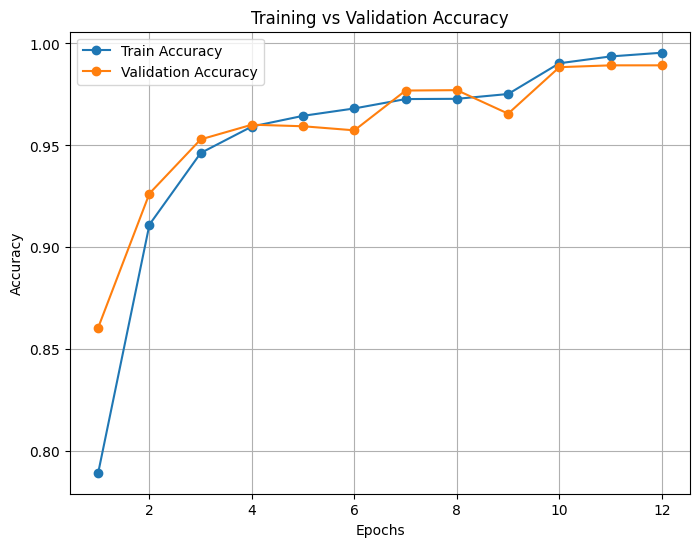

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


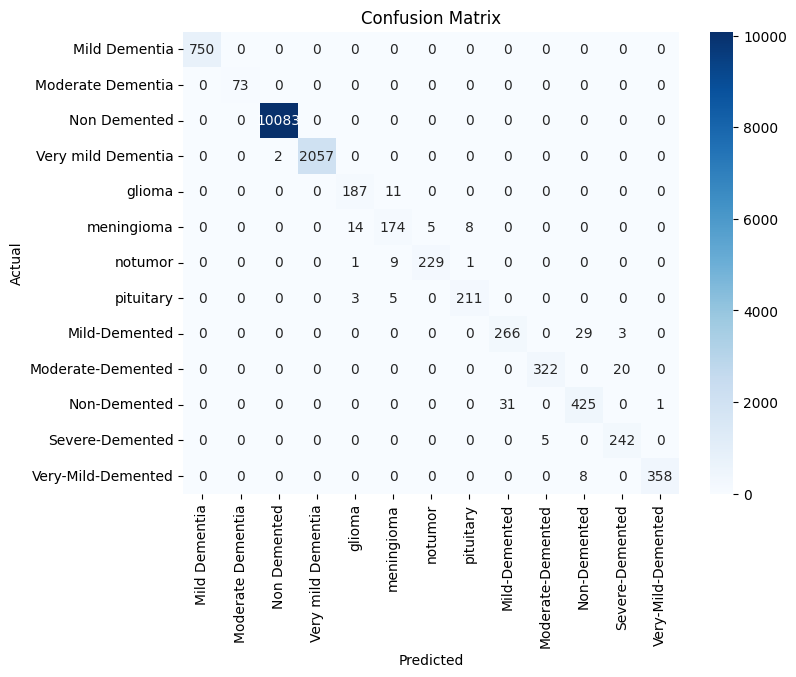


Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       750
 Moderate Dementia       1.00      1.00      1.00        73
      Non Demented       1.00      1.00      1.00     10083
Very mild Dementia       1.00      1.00      1.00      2059
            glioma       0.91      0.94      0.93       198
        meningioma       0.87      0.87      0.87       201
           notumor       0.98      0.95      0.97       240
         pituitary       0.96      0.96      0.96       219
     Mild-Demented       0.90      0.89      0.89       298
 Moderate-Demented       0.98      0.94      0.96       342
      Non-Demented       0.92      0.93      0.92       457
   Severe-Demented       0.91      0.98      0.95       247
Very-Mild-Demented       1.00      0.98      0.99       366

          accuracy                           0.99     15533
         macro avg       0.96      0.96      0.96     15533
      weighte

In [ ]:
# Evaluation on Test Set
# -------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.class_to_idx.keys(), yticklabels=dataset.class_to_idx.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.class_to_idx.keys()))